<a href="https://colab.research.google.com/github/ivyclare/60_Days_of_Udacity/blob/master/EDA_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Segmentation With UNet

ref: [Follow Link](https://github.com/deadskull7/One-Stop-for-COVID-19-Infection-and-Lung-Segmentation-plus-Classification)

In [1]:
# !pip install imgaug                     # for image augmentation https://github.com/aleju/imgaug
# !pip install -U segmentation-models     # ONLY used for dice metric and IOU metric computation, models are made from scratch https://github.com/qubvel/segmentation_models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pwd
# %cd /content/drive/My\ Drive/Colab\ Notebooks/CovidSegmentation/KaggleDataset

/content


In [15]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift

import imgaug as ia
import imgaug.augmenters as iaa

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
GPU is available


In [5]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler,TensorBoard
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
import segmentation_models as sm

Segmentation Models: using `keras` framework.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### Data Acquisition

In [7]:
# # ! pip install -q kaggle


# !mkdir .kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# !pip install kaggle
# # download New API Key from My Account
# # from google.colab import files
# # files.upload()

# !mkdir .kaggle

# import json
# token = {"username":"ivyclare","key":"8b0b9df4293a9561cf2cd8d8fdfc6fcc"}
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)

# !chmod 600 /content/.kaggle/kaggle.json

# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
 
# # !kaggle config set -n path -v{/content}

# !kaggle datasets download -d andrewmvd/covid19-ct-scans
# # !unzip \*.zip
# !unzip \*.zip -d covid19-ct-scans

In [9]:
# Read and examine metadata
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.head(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
1,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
2,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
3,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
4,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...


In [10]:
raw_data.shape

(20, 4)

## Data Preprocessing

1.   Removing incomplete and faulty images
2.   Separate model for empty mask prediction
3.   Use of Contrast Limited Adaptive Histogram Equalization for image enhancement
4.   Cropping the Region of Interst (ROI) using Otsu's binarization and other approaches
5.   Data Augmentation

In [11]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/CovidSegmentation/KaggleDataset
from preprocess_helper import *
from utils import *

/content/drive/My Drive/Colab Notebooks/CovidSegmentation/KaggleDataset


### Total Number of Slices in Dataset

In [32]:
total_cts, total_infections, total_lung = 0,0,0
for i in range(raw_data.shape[0]):
  cts_file = []
  read_nii_demo(raw_data.loc[i,'ct_scan'], cts_file)
  cts_file = np.array(cts_file)
  total_cts += cts_file.shape[0]

  inf_file = []
  read_nii_demo(raw_data.loc[i,'infection_mask'], inf_file)
  inf_file = np.array(inf_file)
  total_infections += inf_file.shape[0]

  lung_file = []
  read_nii_demo(raw_data.loc[i,'lung_mask'], lung_file)
  lung_file = np.array(lung_file)
  total_lung += lung_file.shape[0]

print("Total Number of CT Scans: ",total_cts )
print("Total Number of Infection Masks: ",total_infections )
print("Total Number of Lung Masks: ",total_lung )

/content/drive/My Drive/Colab Notebooks/CovidSegmentation/KaggleDataset/utils.py:63: RuntimeWarning: invalid value encountered in true_divide
  img = (img - xmin)/(xmax - xmin)


Total Number of CT Scans:  2112
Total Number of Infection Masks:  2112
Total Number of Lung Masks:  2112


### Use of Contrast Limited Adaptive Histogram Equalization for image enhancement
Notice how the seahorse shaped infection in the left lung can be distinguised clearly after enhancement.

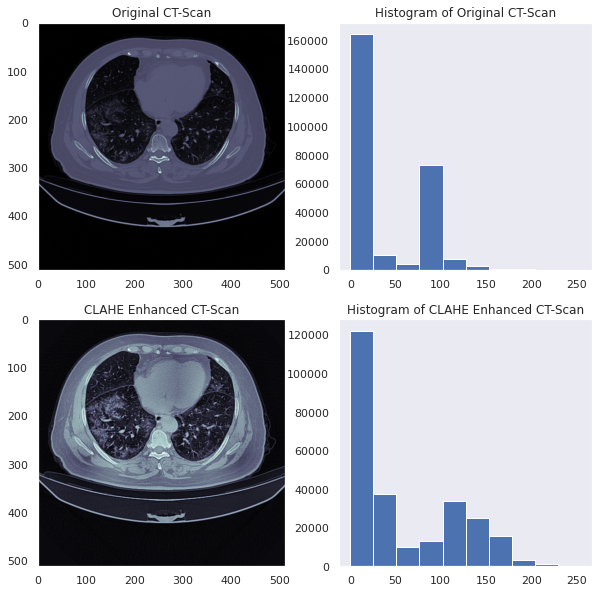

In [24]:
test_file = []
read_nii_demo(raw_data.loc[0,'ct_scan'], test_file)
test_file = np.array(test_file)
rcParams['figure.figsize'] = 10, 10
clahe_image = clahe_enhancer(test_file[60], demo = 1)

Now, we apply clahe enhancer to all images

In [13]:
# read and enhance all slices
for i in range(0, 20):
    read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
    read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts') 
    read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

/content/drive/My Drive/Colab Notebooks/CovidSegmentation/KaggleDataset/utils.py:93: RuntimeWarning: invalid value encountered in true_divide
  img = (img - xmin)/(xmax - xmin)


(250, 250) (250, 250)


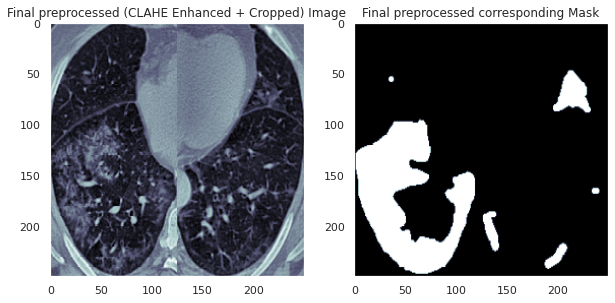

In [16]:
# View Preprocessed Samples
x = 60

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(infections[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(cts[x].shape, infections[x].shape)

### Removing blank/black masks

In [19]:
no_masks = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    no_masks.append(i)
print("Number of completely black masks :" , len(no_masks))

# delete mask and image
for index in sorted(no_masks, reverse = True):  
    del infections[index]  
    del cts[index]

Number of completely black masks : 0


In [20]:
print(len(cts) , len(infections))

1615 1615


After cleaning, we have 1615 samples in our dataset

## Resize and Save Clean Dataset

In [21]:
new_dim = 224
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # cts[i] = cts[i]/255
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # infections[i] = infections[i]/255

In [22]:
# save to numpy array
cts = np.array(cts)
infections = np.array(infections)

In [ ]:
cts = np.uint8(cts)
infections = np.uint8(infections)

In [35]:
clean_data = "/content/drive/My Drive/Colab Notebooks/CovidSegmentation/KaggleDataset/data"

joblib.dump(cts, f'{clean_data}/cts_cropped_lungs_224.pkl')
files.download(f'{clean_data}/cts_cropped_lungs_224.pkl')

joblib.dump(infections, f'{clean_data}/infections_cropped_lungs_224.pkl')
files.download(f'{clean_data}/infections_cropped_lungs_224.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
cts = joblib.load(f'{clean_data}/cts_cropped_lungs_224.pkl')
infections = joblib.load(f'{clean_data}/infections_cropped_lungs_224.pkl')
print(cts.shape, infections.shape)

(1615, 224, 224) (1615, 224, 224)


* Just overlaying infection masks over the corresponding CT scans


In [37]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0], cmap='bone')
    # plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    # plt.title('Lung Mask')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0].reshape(img_size,img_size), cmap='bone')
    # plt.imshow(array_list[1].reshape(img_size, img_size), alpha=0.5, cmap=color_map)
    # plt.title('Lung and Infection Mask')

#     plt.subplot(1,4,4)
#     plt.imshow(array_list[0], cmap='bone')
#     plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
#     plt.title('Lung and Infection Mask')

    plt.show()

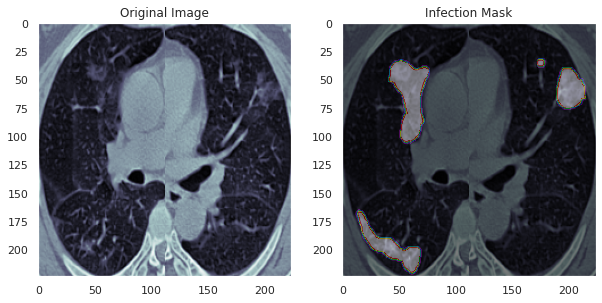

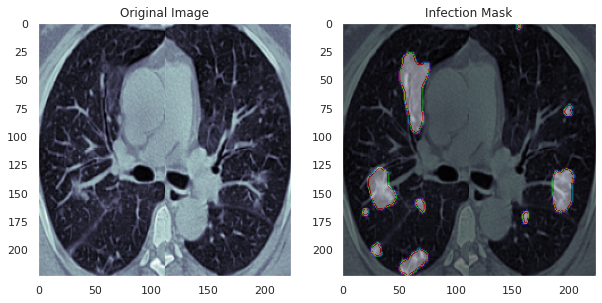

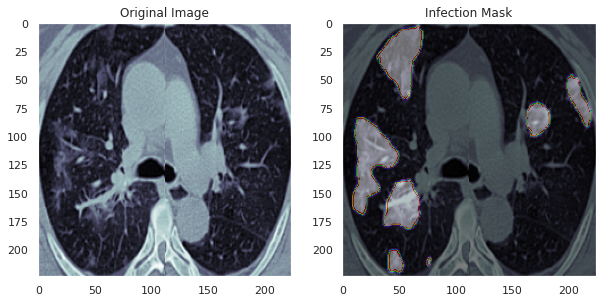

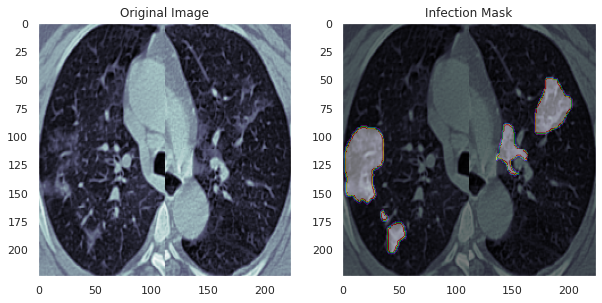

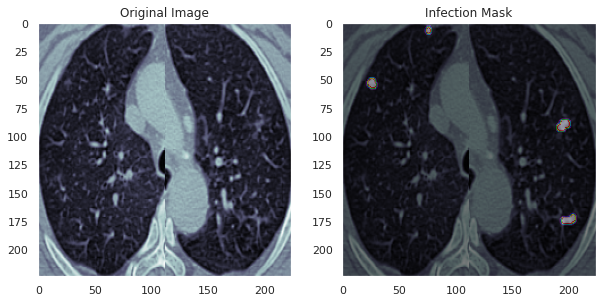

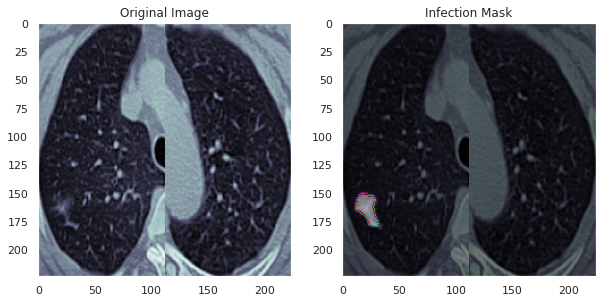

In [38]:
for index in [100,110,120,130,140,150]:
    plot_sample([cts[index], infections[index]])